In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score 

from sklearn.metrics import mean_squared_error

import re

# models
from sklearn.linear_model import LinearRegression
from sklearn.svm import (SVR, LinearSVR)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (RandomForestRegressor, GradientBoostingRegressor)

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
cars = pd.read_csv("cars_train.csv")
print(cars.shape)
cars.head()

(320749, 18)


,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,state,lat,long,posting_date
0,7226069143,indianapolis,3495,2005.0,lincoln,lse,good,8 cylinders,gas,181000.0,automatic,rwd,sedan,silver,in,39.640500,-86.311800,2020-11-05T16:19:56-0500
1,7233322668,medford-ashland,11995,2011.0,subaru,impreza,good,4 cylinders,gas,69408.0,automatic,4wd,wagon,blue,or,45.524894,-122.656061,2020-11-18T15:45:51-0800
2,7239134076,austin,68990,2016.0,porsche,cayman gts coupe 2d,good,NaN,gas,7923.0,automatic,rwd,coupe,red,tx,30.260000,-97.740000,2020-11-30T02:13:53-0600
3,7238509078,hawaii,17900,2011.0,bmw,535i,NaN,NaN,gas,50193.0,automatic,NaN,sedan,black,hi,21.293854,-157.837158,2020-11-28T13:57:30-1000
4,7236364831,daytona beach,9500,2006.0,NaN,mazada miata,excellent,4 cylinders,gas,52864.0,automatic,rwd,convertible,blue,fl,29.172023,-81.027367,2020-11-24T12:48:43-0500


# Data exploration

In [4]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320749 entries, 0 to 320748
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            320749 non-null  int64  
 1   region        320749 non-null  object 
 2   price         320749 non-null  int64  
 3   year          320006 non-null  float64
 4   manufacturer  308004 non-null  object 
 5   model         317348 non-null  object 
 6   condition     185823 non-null  object 
 7   cylinders     200831 non-null  object 
 8   fuel          318505 non-null  object 
 9   odometer      281926 non-null  float64
 10  transmission  319039 non-null  object 
 11  drive         226666 non-null  object 
 12  type          241851 non-null  object 
 13  paint_color   222189 non-null  object 
 14  state         320749 non-null  object 
 15  lat           315562 non-null  float64
 16  long          315562 non-null  float64
 17  posting_date  320730 non-null  object 
dtypes: f

In [5]:
cars.describe()

,id,price,year,odometer,lat,long
count,3.207490e+05,3.207490e+05,320006.000000,2.819260e+05,315562.000000,315562.000000
mean,7.235234e+09,3.867085e+04,2010.740930,9.685220e+04,38.536585,-94.351229
std,4.591287e+06,7.418730e+06,8.858039,2.739514e+05,5.853855,18.060558
min,7.209028e+09,0.000000e+00,1900.000000,0.000000e+00,-79.809640,-159.713745
25%,7.231955e+09,4.900000e+03,2008.000000,4.093500e+04,34.606000,-110.866049
50%,7.236410e+09,1.099500e+04,2013.000000,8.776700e+04,39.260000,-88.310560
75%,7.239315e+09,2.149500e+04,2016.000000,1.340000e+05,42.484503,-81.024100
max,7.241019e+09,2.857993e+09,2021.000000,1.234598e+08,76.781734,150.898969


In [6]:
#Exploring categorical columns
cat_vars = cars.select_dtypes(include=['object']).columns.tolist()

for i in cars[cat_vars].columns:
    print("For variable ",i)
    print(cars[i].value_counts())

For variable  region
columbus               2712
rochester              2494
jacksonville           2451
springfield            2309
redding                2136
                       ... 
siskiyou county          16
susanville                9
west virginia (old)       7
fort smith, AR            7
sioux city, IA            1
Name: region, Length: 405, dtype: int64
For variable  manufacturer
ford               55793
chevrolet          45402
toyota             27063
honda              18026
nissan             16511
jeep               14909
ram                12326
gmc                12071
dodge              11669
bmw                 8642
hyundai             7716
mercedes-benz       7434
volkswagen          7395
subaru              7353
kia                 6241
chrysler            5271
lexus               4986
cadillac            4732
buick               4228
mazda               4131
audi                3899
acura               2777
infiniti            2590
lincoln             2332
pont

Noticed that some categorical columns have so many unique values so they might need feature engineering to assign all rare categories that are less than a specific frequency to one category

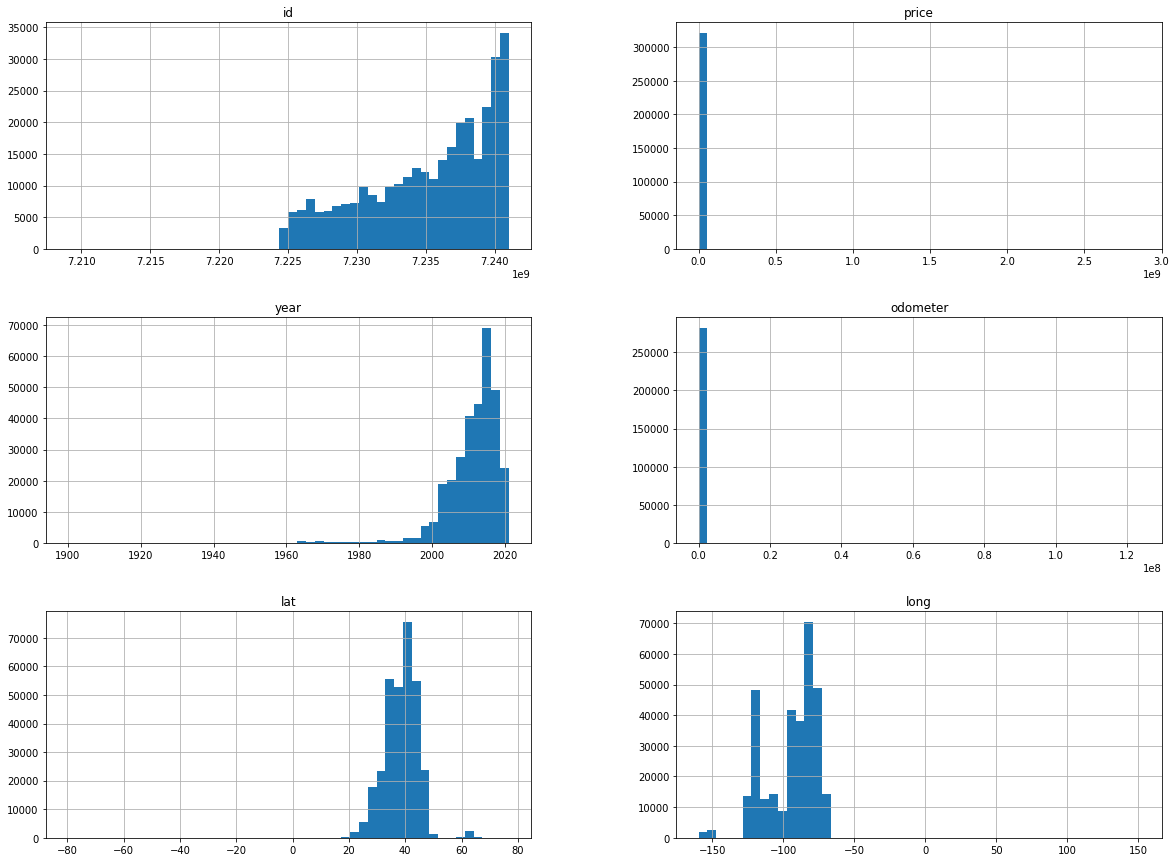

In [7]:
#Exploring numerical columns
cars.hist(bins=50, figsize=(20,15))
plt.show()

Looking at the histograms of numerical features, I noticed from the distribution of 'odometer' and 'price' that they might be suffering from outliers

In [8]:
corr_matrix = cars.corr()

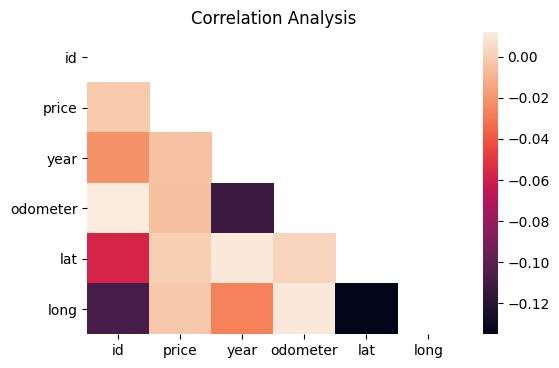

In [9]:
mask = np.triu(np.ones_like(corr_matrix,dtype = bool))
plt.figure(dpi=100)
ax = plt.axes()
sns.heatmap(corr_matrix,annot=False, mask=mask,lw=0,linecolor='white',fmt = "0.2f")
plt.title('Correlation Analysis')
plt.axis('tight')
plt.show()

In [10]:
#Correlation with the target
corr_matrix["price"].sort_values(ascending=False)

price       1.000000
lat         0.000799
id         -0.000985
long       -0.001573
year       -0.003709
odometer   -0.004784
Name: price, dtype: float64

No numerical feature has interesting correlation with the target

In [11]:
#Missing values
count = cars.isnull().sum().sort_values(ascending=False)
percentage = ((cars.isnull().sum()/len(cars)*100)).sort_values(ascending=False)
missing = pd.concat([count, percentage], axis=1, keys=['Count','Percentage'])
print('Number of columns with missing values:')
print(missing[missing['Count']!= 0].shape[0])

print('Count and percentage of missing values for the columns:')
missing


Number of columns with missing values:
14
Count and percentage of missing values for the columns:


,Count,Percentage
condition,134926,42.065914
cylinders,119918,37.386866
paint_color,98560,30.728077
drive,94083,29.332282
type,78898,24.598050
odometer,38823,12.103857
manufacturer,12745,3.973512
lat,5187,1.617152
long,5187,1.617152
model,3401,1.060331


After investigating percentage of missing values in each column, No column has a large percentage of missing values that suggest to drop it

In [12]:
#Defining lower and upper limits to detect outliers
def outliers(col):
    q1 = np.nanpercentile(col, 25)
    q3 = np.nanpercentile(col, 75)
    iqr = q3 - q1
    lower = q1 - (1.5 * iqr)
    upper = q3 + (1.5 * iqr)
    return lower , upper

In [13]:
lp, hp = outliers(cars['price'])
print(lp,hp)

-19992.5 46387.5


In [14]:
lo, ho = outliers(cars['odometer'])
print(lo,ho)

-98662.5 273597.5


In [15]:
ly,hy= outliers(cars['year'])
print(ly,hy)

1996.0 2028.0


In [16]:
print('Number of cars where price is an outlier :',cars[cars['price'] > hp].shape[0])
print('Number of cars where odometer is an outlier :',cars[cars['odometer'] > ho].shape[0])
print('Number of cars where year is an outlier :',cars[cars['year'] > hy].shape[0])

Number of cars where price is an outlier : 8918
Number of cars where odometer is an outlier : 2621
Number of cars where year is an outlier : 0


In [17]:
print('Number of cars where price is an outlier :', cars[cars['price'] <= 0].shape[0])
print('Number of cars where odometer is an outlier :', cars[cars['odometer'] < lo].shape[0])
print('Number of cars where year is an outlier :', cars[cars['year'] < ly].shape[0])

Number of cars where price is an outlier : 23566
Number of cars where odometer is an outlier : 0
Number of cars where year is an outlier : 11724


In [18]:
def remove_outliers(X):
    lower, upper = outliers(X['price'])
    X = X[(X['price'] <= upper) & (X['price'] > 0)]
    return X
remove_outliers_y = FunctionTransformer(remove_outliers, validate=False)
cars = remove_outliers_y.fit_transform(cars)
cars['price'].max()    



46350

Removed outliers from the target as all the transformations in the pipeline will be applied to the features not the target

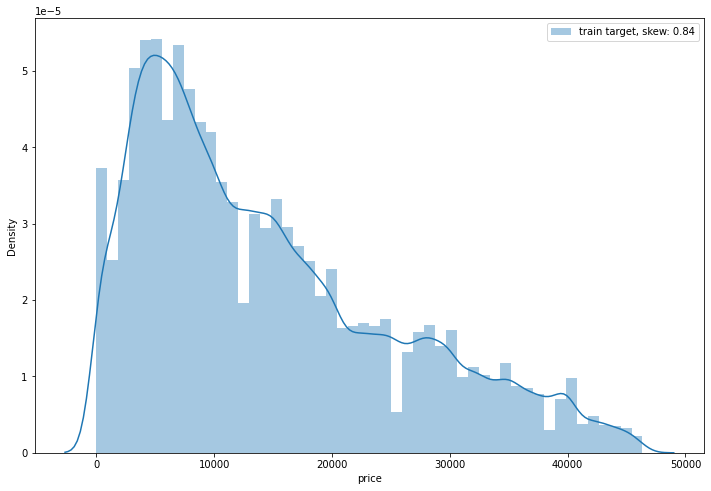

In [19]:
# Visualizing the target variable after removing outliers
y = cars['price']
plt.figure(figsize=(12,8))
sns.distplot(y, label=f'train target, skew: {y.skew():.2f}')
plt.legend(loc='best')
plt.show()

In [20]:
#The mean value of the target: to compare rmse of models to it
np.round(y.mean())

14606.0

In [21]:
print("Number of records after removing the price outliers is: {} records, and {} features ".format(cars.shape[0],cars.shape[1]))
#Checking for duplicates
cars.duplicated().value_counts()

Number of records after removing the price outliers is: 288265 records, and 18 features 


False    288265
dtype: int64

# Base Line System

Started with a baseline model and dropped some columns that seem to not have any predicting power or seem redundancy like 'id', 'posting_date', 'lat','long' and so on

In [22]:
X = cars.drop(['id','price','posting_date','lat','long','model','region'], axis=1)
y = cars['price']

In [23]:
num_vars = X.select_dtypes(include=['float', 'int']).columns.tolist()
cat_vars = X.select_dtypes(include=['object']).columns.tolist()

In [24]:
#Defining categorical columns and numerical columns separately
X_cat = X[[c for c in X.columns if c in cat_vars]]
X_num = X[[c for c in X.columns if c in num_vars]]

Did some basis preprocessing in order to train a Linear regression model as a baseline model

In [25]:
# deal with missing values in categorical columns
# fill these with 'Missing'
def fill_cat_na(X):
    cat_vars_with_na = [col for col in X if (X[col].dtypes == "object") & (X[col].isna().sum() > 0)]
    for var in cat_vars_with_na:
        X[var] = X[var].fillna('Missing')
    return X
    
fill_cat = FunctionTransformer(fill_cat_na, validate=False)


In [26]:
#Encoding categorical features with OneHotEncoding
cat_encoder = OneHotEncoder(sparse=False,handle_unknown='ignore')

In [27]:
#Pipeline for categorical features
cat_pipeline = Pipeline([
        ('imputer', fill_cat),
        ('encoding', cat_encoder),
    ])

In [28]:
#Adding a numerical column 'age' instead of 'year'
def add_age(X):
    X['current_yr'] = 2021
    X['age'] = X['current_yr'] - X['year']
    X = X.drop(['year','current_yr'],axis=1)
    return X

attr_adder = FunctionTransformer(add_age, validate=False)


In [29]:
#Imputing missing values and outliers in the numerical columns with the median of each
from numpy import percentile
def impute_outliers_and_missing(X):
    num_vars = X.select_dtypes(include=['float', 'int']).columns.tolist() 
    for var in num_vars:
        median = X[var].median()
        X[var].fillna(median, inplace=True) 
        lower, upper = outliers(X[var])
        outliers_list = [x for x in X[var] if x < lower or x > upper]
        X[var][X[var].isin(outliers_list)] = median
    return X

outliers_and_missing_impute = FunctionTransformer(impute_outliers_and_missing, validate=False)


In [30]:
#Pipeline for numerical features
num_pipeline = Pipeline([
        ('adder', attr_adder),
        ('imputer', outliers_and_missing_impute),
      ])

In [31]:
#Pipeline to apply on all columns
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_vars),
        ("cat", cat_pipeline, cat_vars),
    ])


In [32]:
def display_scores(scores):
    print("Scores:", np.round(scores))
    print("Mean: ", np.round(scores.mean()))
    print("Stdev:", np.round(scores.std()))


In [35]:
#Linear Regression Model
lin_reg = LinearRegression()

pipeline = Pipeline(steps=[('i', full_pipeline), ('m', lin_reg)])
cv = KFold(n_splits=5, shuffle=True, random_state=1)
# evaluate model
scores = cross_val_score(pipeline, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
print(scores)
lin_rmse_scores = np.sqrt(-scores)
display_scores(lin_rmse_scores)

[-45829069.24041977 -45493136.38215411 -46108941.49478275
 -45371587.8955183  -46708025.87794687]
Scores: [6770. 6745. 6790. 6736. 6834.]
Mean:  6775.0
Stdev: 35.0


After many trials with different preprocessing techniques like Standard Scaler, Robust Scaler, MinMaxScaler, Power Transformation for outliers and others I found that creating 'age' column instead of 'year' and imputing outliers with median and missing values as well and using OneHotEncoding for categorical features is the combination that gave me lower rmse on the Linear regression model of 6775 and standard deviation of 35.
Note: removing outliers within the pipeline would lead to imbalance in samples numbers between X and Y as the pipeline transformations will not apply on Y

# Data engineering and preprocessing

Added some columns again like 'model and 'region' to see if performance would improve

In [36]:
X = cars.drop(['id','price','lat','long','posting_date'], axis=1)
y = cars['price']
X.shape, len(y)

((288265, 13), 288265)

In [37]:
num_vars = X.select_dtypes(include=['float', 'int']).columns.tolist()
cat_vars = X.select_dtypes(include=['object']).columns.tolist()
X_cat = X[[c for c in X.columns if c in cat_vars]]
X_num = X[[c for c in X.columns if c in num_vars]]

In [38]:
#Assigning rare categories that have frequency less than min_perc to one category called 'rare' and removing categorical features with 1 category.
    
def engineer_rare_cat_vars(X,cat_vars=cat_vars, min_perc=0.002):
    to_drop = []
    for col in cat_vars:
            # Find percentage of categories
        percs = X[col].value_counts(normalize=True)
            
            # rare categories are the ones having a % smaller than min_perc
        rare_categories = percs[percs < min_perc].index
            
            # Replace these with "Rare"
        X.loc[X[col].isin(rare_categories), col] = "Rare"
            
        if X[col].nunique() < 2:
            to_drop.append(col)
    
    # drop columns containing one category if they exist
    if to_drop:
        X.drop(columns=to_drop, inplace=True)
    

    return X

In [39]:
engineer_rare_cat = FunctionTransformer(engineer_rare_cat_vars, validate=False)


In [40]:
#Updated pipeline for categorical features
cat_pipeline_new = Pipeline([
        ('engineering', engineer_rare_cat ),
        ('imputer', fill_cat),
        ('encoding', cat_encoder),
    ])

In [41]:
#Updated pipeline for all columns
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_vars),
        ("cat", cat_pipeline_new, cat_vars),
    ])

In [42]:
#Training Linear regression model after the final preprocessing and feature engineering
lin_reg = LinearRegression()
pipeline_l = Pipeline(steps=[('i', full_pipeline), ('l', lin_reg)])
# define model evaluation
cv = KFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(pipeline_l, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)
print(scores)
lin_rmse_scores = np.sqrt(-scores)
display_scores(lin_rmse_scores)

[-43842337.92205667 -44118201.10805392 -44316777.13505259
 -43914646.6199821  -45217882.72474106]
Scores: [6621. 6642. 6657. 6627. 6724.]
Mean:  6654.0
Stdev: 37.0


After adding categorical feature engineering to the pipeline, the rmse of the baseline model lowered to 6654 with a standard deviation of 37

# Model Optimization and Selection

In [ ]:
#DecisionTreeRegressor
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(random_state=42)
pipeline_t = Pipeline(steps=[('i', full_pipeline), ('t', tree_reg)])
scores = cross_val_score(pipeline_t, X, y,
                         scoring="neg_mean_squared_error", cv=5)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Scores: [5465. 5405. 5488. 5502. 5459.]
Mean:  5464.0
Stdev: 33.0


In [ ]:
#RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=10, random_state=42)
pipeline_f = Pipeline(steps=[('i', full_pipeline), ('f', forest_reg)])
forest_scores = cross_val_score(pipeline_f, X, y,
                                scoring="neg_mean_squared_error", cv=5)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [4337. 4335. 4353. 4418. 4404.]
Mean:  4369.0
Stdev: 35.0


In [ ]:
#GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
gb_reg = GradientBoostingRegressor(random_state= 42, n_estimators=10)
pipeline_g = Pipeline(steps=[('i', full_pipeline), ('g', gb_reg)])
gbr_scores = cross_val_score(pipeline_g, X, y,
                                scoring="neg_mean_squared_error", cv=5)
gbr_rmse_scores = np.sqrt(-gbr_scores)
display_scores(gbr_rmse_scores)

Scores: [7995. 8024. 8016. 8033. 7998.]
Mean:  8013.0
Stdev: 15.0


Trained data with 5-fold cross validations on the previous models as well as SVR with kernel="linear" and LinearSVR but the last two were very slow and memory consuming so I dropped them from my experiments and since RandomForestregressor resulted in the lowest rmse of 4369 with a standard deviation of 35, I wanted to optimize it more using Gridsearch by changing n_estimators and max_features hyperparameters

In [43]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [10, 50], 'max_features': [100, 300]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (4)*5=20 rounds of training 
grid_search = Pipeline([('i', full_pipeline), ('grid_search', GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True))])

grid_search.fit(X, y)

Pipeline(memory=None,
         steps=[('i',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('adder',
                                                                   FunctionTransformer(accept_sparse=False,
                                                                                       check_inverse=True,
                                                                                       func=<function add_age at 0x7fd1b7f927a0>,
                                                                                       inv_kw_args=None,
                                                                                       inverse_func=None,
           

In [44]:
grid_search.named_steps['grid_search'].best_params_

{'max_features': 100, 'n_estimators': 50}

In [45]:
grid_search.named_steps['grid_search'].best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=100, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [46]:
grid_cv_res = grid_search.named_steps['grid_search'].cv_results_
for mean_score, params in zip(grid_cv_res["mean_test_score"], grid_cv_res["params"]):
    print(f"score = {np.round(np.sqrt(-mean_score))} <- parameters {params}")

score = 4181.0 <- parameters {'max_features': 100, 'n_estimators': 10}
score = 3987.0 <- parameters {'max_features': 100, 'n_estimators': 50}
score = 4238.0 <- parameters {'max_features': 300, 'n_estimators': 10}
score = 4076.0 <- parameters {'max_features': 300, 'n_estimators': 50}


So the optimzed model based on GridSearch was RandomForestRegressor with max_feature of 100 and n_estimators of 50 with the lowest rmse of 3987 

# Feature Selection

In [ ]:
#Getting feature importances from GridSearch
feature_importances = grid_search.named_steps['grid_search'].best_estimator_.feature_importances_
print(len(feature_importances))
feature_importances

393


array([1.79263968e-01, 2.72541748e-01, 3.39003392e-03, 6.19125942e-04,
       2.75029700e-04, 2.70518046e-04, 3.50880334e-04, 4.05246302e-04,
       1.26373294e-04, 1.31499165e-04, 2.58296851e-04, 3.29984875e-04,
       3.92988286e-04, 3.89664594e-04, 2.79397168e-04, 5.43429492e-04,
       9.38565119e-04, 3.37952861e-04, 2.64794884e-04, 4.84276219e-04,
       4.96522050e-04, 1.83705465e-04, 1.97862586e-04, 3.54862746e-04,
       2.16906664e-04, 6.43810969e-04, 1.45756894e-04, 9.72148823e-04,
       1.32667855e-04, 3.14968271e-04, 3.82361069e-04, 3.19599830e-04,
       1.33320625e-04, 7.42801196e-05, 4.40091274e-04, 1.34130224e-04,
       4.91880700e-04, 5.15403906e-04, 2.27461637e-04, 4.35037169e-04,
       5.62942043e-05, 3.36612195e-04, 2.51814137e-04, 8.43678465e-04,
       1.08137814e-04, 3.25054800e-04, 1.07580396e-04, 4.63222802e-04,
       8.26484742e-04, 1.90841874e-04, 3.42230567e-04, 1.75777868e-04,
       1.12412014e-04, 2.44254123e-04, 7.23528996e-05, 9.05380545e-05,
      

In [ ]:
#Getting names of columns after all the transformations including OneHotEncoding
X_cat1 = X_cat.copy()
X_cat1= cat_pipeline_new.fit_transform(X_cat1)
cat_cols_ohe = list(cat_encoder.get_feature_names(input_features=cat_vars))
col_names = ['odometer','age'] + cat_cols_ohe 
len(col_names)


393

There are now 393 features after all transformations so i tried to reduce them based on feature importance 

In [ ]:
#Sorting features based on importance and defining the top three features
feature_imp = pd.DataFrame(sorted(zip(grid_search.named_steps['grid_search'].best_estimator_.feature_importances_, col_names)), columns=['Value','Feature'])
features_df = feature_imp.sort_values(by="Value", ascending=False)
features_df.head(3)

,Value,Feature
392,0.272542,age
391,0.179264,odometer
390,0.037196,drive_fwd


The top three powerful predictors are 'age','odometer' and 'drive_fwd'

In [ ]:
#The selected features as the top 100 important features
selected_features = features_df.Feature[:100]
selected_features


392                          age
391                     odometer
390                    drive_fwd
389                    drive_4wd
388                  type_pickup
                 ...            
297    region_mcallen / edinburg
296                   model_1500
295         region_south florida
294                     state_ia
293         region_new hampshire
Name: Feature, Length: 100, dtype: object

In [ ]:
#Dropping less important features
def drop_features(X):
    X= pd.DataFrame(X, columns= col_names)
    X= X[selected_features]
    return X
features_drop = FunctionTransformer(drop_features, validate=False)


In [ ]:
#The final pipeline after dropping less important features
final_pipeline = Pipeline([
        ('full', full_pipeline),
        ('drop_f', features_drop),
    ])

In [ ]:
#RandomForestRegressor after selecting important features
rf = RandomForestRegressor(n_estimators=50, random_state=42)
pipeline_ff = Pipeline(steps=[('fp', final_pipeline), ('rf', rf)])
forest_scores_ff = cross_val_score(pipeline_ff, X, y,
                                scoring="neg_mean_squared_error", cv=5)
forest_rmse_scores_ff = np.sqrt(-forest_scores_ff)

np.round(np.nanmean(forest_rmse_scores_ff))

4619.0

Trained RandomForestRegressor on the selected features (I chose to keep the top 100) with 5-fold cross validations, the rmse was 4619, it's higher than the optimized one I got from GridSearch before reducing features by 15.85% but decrease in features was 74.55%. Note: got some NaN in cross validation scores but I was still able to get average rmse

In [ ]:
#Feature selection with RFECV
from sklearn.feature_selection import RFECV

X_rfe = full_pipeline.fit_transform(X)
min_features_to_select = 100  # Minimum number of features to consider
rf = RandomForestRegressor(n_estimators=50, random_state=42)
rfecv = RFECV(estimator=rf, step=10, cv=5,
              scoring='neg_mean_squared_error',
              min_features_to_select=min_features_to_select)
rfecv.fit(X_rfe, y)

rfecv.score(X_rfe,y)

0.9785545120148329

In [ ]:
rfecv.n_features_

333

In [ ]:
np.sqrt(-rfecv.grid_scores_)

array([4218.81065043, 4211.63336631, 4205.7327279 , 4188.12081528,
       4179.4675015 , 4173.00987773, 4168.42281857, 4167.32114551,
       4161.67483883, 4159.71903885, 4157.83570923, 4151.91968483,
       4151.09796728, 4149.71122566, 4150.87551431, 4147.90999158,
       4146.40618011, 4146.03374799, 4145.10542312, 4143.39724867,
       4144.84543741, 4143.6438536 , 4144.19786796, 4143.0811877 ,
       4141.18664075, 4143.07275373, 4143.62526138, 4144.91920352,
       4145.06506011, 4146.86799279, 4143.22891465])

In [ ]:
rfecv.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 6, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1,
       3, 1, 4, 1, 1, 1, 1, 1, 3, 1, 6, 5, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 5, 1, 2, 4, 5, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 6, 1, 1, 1,
       1, 1, 1, 7, 1, 2, 5, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 4, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 6, 1, 1, 1, 1, 5, 1, 2, 1, 4, 3, 3, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 1, 1, 6, 1, 5, 1, 1, 1, 1, 1, 3, 2,
       4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 6, 4, 1, 1, 1, 1, 1, 1, 1,
       2, 1, 7, 1, 3, 4, 1, 1, 1, 3, 1, 1, 4, 1, 5, 1, 1, 7, 5, 6, 1, 7,
       6, 1, 5, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 1, 1, 7, 6, 1, 1, 1, 1, 7,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
model_rfe = rfecv.estimator_

In [ ]:
pipeline_rfecv = Pipeline(steps=[('i', full_pipeline), ('rfe', model_rfe)])
rfecv_scores = cross_val_score(pipeline_rfecv , X, y,
                                scoring="neg_mean_squared_error", cv=5)
rfecv_rmse_scores = np.sqrt(-rfecv_scores)
display_scores(rfecv_rmse_scores)

Scores: [4157. 4168. 4188. 4243. 4239.]
Mean:  4199.0
Stdev: 36.0


After trying to reduce features with RFECV, it kept 333 features out of 393, then it reduced features by only 15.27% and the resulted rmse of 4199 was higher than my optimized chosen model by 5.32%. Although RFECV increased rmse in less amount comapred to feature selection that I did based on feature_importances_ attribute, but it didn't lower complexity of model well, and it took more than 24 hours running

So, I decided to go with my chosen model RandomForestRegressor that was optimized with GridSearch without dropping features as the number of features is only 393 and the increase in rmse after dropping features was big relatively

# Optimizing an interpretable model (Decision Tree)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'max_depth': [10, 30], 'max_features': ['auto','sqrt']},
  ]

tree_reg = DecisionTreeRegressor(random_state=42)
# train across 5 folds, that's a total of (4)*5=20 rounds of training 
grid = Pipeline([('i', full_pipeline), ('grid', GridSearchCV(tree_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True))])

grid.fit(X, y)

Pipeline(memory=None,
         steps=[('i',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('adder',
                                                                   FunctionTransformer(accept_sparse=False,
                                                                                       check_inverse=True,
                                                                                       func=<function add_age at 0x7f67f784c170>,
                                                                                       inv_kw_args=None,
                                                                                       inverse_func=None,
           

In [ ]:
grid.named_steps['grid'].best_params_

{'max_depth': 30, 'max_features': 'auto'}

In [ ]:
grid_cv_res = grid.named_steps['grid'].cv_results_
for mean_score, params in zip(grid_cv_res["mean_test_score"], grid_cv_res["params"]):
    print(f"score = {np.round(np.sqrt(-mean_score))} <- parameters {params}")

score = 6182.0 <- parameters {'max_depth': 10, 'max_features': 'auto'}
score = 7790.0 <- parameters {'max_depth': 10, 'max_features': 'sqrt'}
score = 5282.0 <- parameters {'max_depth': 30, 'max_features': 'auto'}
score = 6373.0 <- parameters {'max_depth': 30, 'max_features': 'sqrt'}


Now, before doing the final test I tried to optimize an interpretable model like DecissionTreeRegressor using GridSearch, the optimized one was of max_depth of 30 and max_features of 'auto' but the resulting rmse was 5282 wich is less than the previous performance of DecissionTreeRegressor of 5464 but still far higher than our chosen RandomForestRegressor so didn't go with it

# Evaluation on Test Set

In [47]:
#Getting test data
cars_test = pd.read_csv("cars_test.csv")
print(cars_test.shape)

(137464, 18)


In [48]:
cars_test = remove_outliers_y.transform(cars_test)

In [49]:
X_test = cars_test.drop(['id','price','lat','long','posting_date'], axis=1)
y_test = cars_test['price']

In [52]:
#Evaluating performance of final model on test data
final_model = grid_search.named_steps['grid_search'].best_estimator_
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.round(np.sqrt(final_mse))
final_rmse

3893.0

I applied the pipeline on the test data to predict it using my chosen model and the resulting rmse was 3893

Finally, based on the learning curve when errors on both train and test data alomst converge then adding more data is very unlikely to help and here rmse on validation was 3987 while on test it's only 3893 they are very close so I'll not recommend adding data

Voila!